# Summary

This notebook exemplifies the usage of darts library https://unit8co.github.io/darts/ for timeseries forecasting/reconstruction. 

After predicting the forecast/reconstruction the package pythresh is used to find optimal thresholds and predict anomalies based on prediction errors.

In [1]:
import sys
sys.path.append('../src')
import evaluation_utils, data_utils

from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
    VARIMA,
)
from darts.utils.callbacks import TFMProgressBar

from darts import TimeSeries
import numpy as np
import pandas as pd
import json
def generate_torch_kwargs():
    # run torch models on CPU, and disable progress bars for all model stages except training.
    return {
        "pl_trainer_kwargs": {
            "accelerator": "cpu",
            "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        }
    }

X shape: (1831, 21), y shape: (1831,)


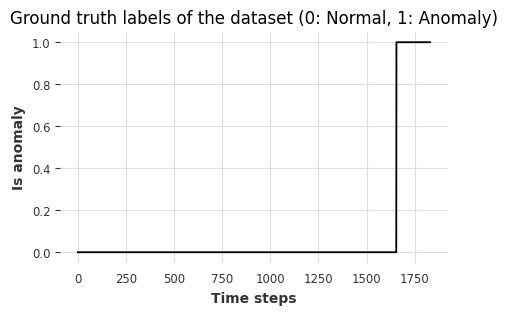

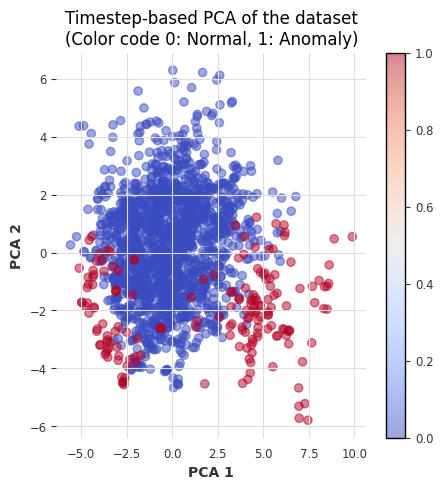

In [2]:
# Data loading
X, y = data_utils.get_data('../data/6_cardio.npz')
data_utils.plot_dataset(X, y)

To illustrate the forecasting method, the input dataset has to be split into a training and a test set (i.e. containing the forecasted components).

In [3]:
n = len(X) # Total number of samples in the dataset
train_ratio = 0.7 # Percentage of samples used for training

# Create a DatetimeIndex that is required by the Darts library
time_index = pd.date_range(start='2020-01-01', periods=n, freq='D')
train_size = int(len(X) * train_ratio) # Number of samples used for training
X_train, y_train, index_train = X[:train_size], y[:train_size], time_index[:train_size]
X_test, y_test, index_test = X[train_size:], y[train_size:], time_index[train_size:]

In [4]:
# Darts library expects as input a list of TimeSeries objects
train_time_series_list = [
    TimeSeries.from_times_and_values(index_train, col) for col in X_train.T]
test_time_series_list = [
    TimeSeries.from_times_and_values(index_test, col) for col in X_test.T]

In [5]:
# Model definition
model = NBEATSModel(
    input_chunk_length=1000,
    output_chunk_length=200,
    n_epochs=5,
    random_state=0,
    **generate_torch_kwargs()
)

In [6]:
# Model training
model.fit(train_time_series_list)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 13.9 M
---------------------------------------------------
13.9 M    Trainable params
7.3 K     Non-trainable params
13.9 M    Total params
55.608    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=1000, output_chunk_length=200, n_epochs=5, random_state=0, pl_trainer_kwargs={'accelerator': 'cpu', 'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x0000020BFF54ECD0>]})

# Forecasting approach
To identify anomalies from the predicted timeseries, a thresholding approach needs to be applied to binarize the predicted values (is anomaly).

Below we illustrate the difference in performance brought by exploring 2 thresholding techniques (filter, aucp)

In [7]:
pred = model.predict(n=len(X_test), series=train_time_series_list)
pred = np.array([p.values().reshape(-1) for p in pred]).T

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## First thresholding approach using the aucp method

In [8]:
predicted_anomalies = evaluation_utils.threshold_anomalies(X_test, pred, method="aucp")
predicted_anomalies = np.array(predicted_anomalies).reshape(-1)
# Evaluation
scores = evaluation_utils.run_evaluation(y_test, predicted_anomalies, do_point_adjustment=True)
# pretty print results
print(json.dumps(scores, indent=4))
# save results to a file
data_utils.save_results(f"results/darts NBEATSModel aucp thresholding.npz", scores)

{
    "AUCROC": 0.18816844919786097,
    "AUCPR": 0.2891059602649007,
    "F1": 0.4848448117817289,
    "Precision": 0.32,
    "Recall": 1.0,
    "Adjusted AUCROC": 0.625668449197861,
    "Adjusted AUCPR": 0.38596491228070173,
    "Adjusted F1": 0.5569580067586855,
    "Adjusted Precision": 0.38596491228070173,
    "Adjusted Recall": 1.0
}
Results saved to results/darts NBEATSModel aucp thresholding.npz


## Second thresholding approach using the filter method

In [9]:
predicted_anomalies = evaluation_utils.threshold_anomalies(X_test, pred, method="filter")
predicted_anomalies = np.array(predicted_anomalies).reshape(-1)
# Evaluation
scores = evaluation_utils.run_evaluation(y_test, predicted_anomalies, do_point_adjustment=True)
# pretty print results
print(json.dumps(scores, indent=4))
# save results to a file
data_utils.save_results(f"results/darts NBEATSModel filter thresholding.npz", scores)

{
    "AUCROC": 0.42914438502673796,
    "AUCPR": 0.32,
    "F1": 0.4848448117817289,
    "Precision": 0.32,
    "Recall": 1.0,
    "Adjusted AUCROC": 0.42914438502673796,
    "Adjusted AUCPR": 0.32,
    "Adjusted F1": 0.4848448117817289,
    "Adjusted Precision": 0.32,
    "Adjusted Recall": 1.0
}
Results saved to results/darts NBEATSModel filter thresholding.npz
